In [1]:
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))

sys.path.append(parent_dir)

In [2]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

from generators.data_generation import generate_sequences
from model_managers.GodoyStepByStep import StepByStep

In [3]:
# Create a sequence of points of a perfect square
seq = (torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4 ,2))
seq, seq.shape

(tensor([[[-1., -1.],
          [-1.,  1.],
          [ 1.,  1.],
          [ 1., -1.]]]),
 torch.Size([1, 4, 2]))

In [4]:
source_seq = seq[:, :2]
target_seq = seq[:, 2:]

In [5]:
source_seq, target_seq

(tensor([[[-1., -1.],
          [-1.,  1.]]]),
 tensor([[[ 1.,  1.],
          [ 1., -1.]]]))

In [6]:
from models.encoders.simple_encoder import EncoderV0
from models.decoders.simple_decoder import DecoderV0

In [7]:
torch.manual_seed(18)
encoder = EncoderV0(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq)
hidden_final = hidden_seq[:, -1:]
hidden_seq.shape, hidden_final

# hidden_seq has 2 timesteps because my input is a sequence of length 2, so the last hidden_state is the output 

(torch.Size([1, 2, 2]), tensor([[[0.3739, 0.5657]]], grad_fn=<SliceBackward0>))

In [8]:
torch.manual_seed(18)
decoder = DecoderV0(n_features=2, hidden_dim=2)
decoder.init_hidden(hidden_seq)
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
    print(f"Hidden: {decoder.hidden}")
    out = decoder(inputs)
    print(f"Output: {out}\n")
    inputs = out

Hidden: tensor([[[0.3739, 0.5657]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.4316, -0.0251]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[0.3407, 0.7289]]], grad_fn=<StackBackward0>)
Output: tensor([[[-0.3913,  0.0825]]], grad_fn=<ViewBackward0>)



We got a model that is using its own prediction to predict the next token, this is not good. We have to find a way to train it from some ground truth.

## Teacher Forcing Technique

Teacher forcing in sequence-to-sequence models uses the actual target outputs during training to guide the decoder's learning process. Instead of its own previously generated outputs, the decoder receives the correct target tokens at each time step. This approach stabilizes training, accelerates convergence, and helps the model learn the mapping from inputs to outputs more effectively, ensuring accurate sequence generation.

In [9]:
torch.manual_seed(18)
decoder = DecoderV0(n_features=2, hidden_dim=2)
decoder.init_hidden(hidden_seq)
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
    print(f"Hidden: {decoder.hidden}")
    out = decoder(inputs)
    print(f"Output: {out}\n")

    # ignore predictions and use real data as input
    inputs = target_seq[:, i:i+1]

Hidden: tensor([[[0.3739, 0.5657]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.4316, -0.0251]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[0.3407, 0.7289]]], grad_fn=<StackBackward0>)
Output: tensor([[[-0.5107,  0.2540]]], grad_fn=<ViewBackward0>)



The problem with teacher forcing is that the model isnt robust, it doesnt generalize well on unseen data ( predictions generated by itself ).

In [10]:
# We can make it more robust using the teacher forcing and the normal way randomly every iteration.

torch.manual_seed(18)
decoder = DecoderV0(n_features=2, hidden_dim=2)
decoder.init_hidden(hidden_seq)
inputs = source_seq[:, -1:]

target_len = 2
teacher_force_prob = 0.5
for i in range(target_len):
    print(f"Hidden: {decoder.hidden}")
    out = decoder(inputs)
    print(f"Output: {out}\n")

    if torch.rand(1) <= teacher_force_prob:     
        # ignore predictions and use real data as input
        inputs = target_seq[:, i:i+1]
    else:
        inputs = out

Hidden: tensor([[[0.3739, 0.5657]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.4316, -0.0251]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[0.3407, 0.7289]]], grad_fn=<StackBackward0>)
Output: tensor([[[-0.5107,  0.2540]]], grad_fn=<ViewBackward0>)



In [11]:
from models.enc_decs.simple_enc_dec import EncoderDecoderV0

encdec = EncoderDecoderV0(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=0.5)

In [12]:
encdec.train() # this is the mode -> self.training = True
encdec(seq)

tensor([[[-0.4316, -0.0251],
         [-0.5107,  0.2540]]], grad_fn=<CopySlices>)

In [13]:
encdec.eval()
encdec(source_seq)

tensor([[[-0.4316, -0.0251],
         [-0.3913,  0.0825]]], grad_fn=<CopySlices>)

### Put all together

In [14]:
from generators.data_generation import generate_sequences

In [15]:
points, _ = generate_sequences(n=512, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]
target_train

/tmp/ipykernel_11676/2311727765.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  full_train = torch.as_tensor(points).float()


tensor([[[-0.8963, -1.1319],
         [-1.0194,  1.0588]],

        [[ 0.8617,  1.0233],
         [ 1.0532, -1.1370]],

        [[-0.8563, -1.0580],
         [-1.0162,  1.1339]],

        ...,

        [[ 0.9665,  1.0629],
         [ 0.9079, -1.0732]],

        [[-0.9203, -1.0616],
         [-0.9083,  0.9985]],

        [[-1.0234, -0.9967],
         [ 1.0440, -0.9607]]])

In [16]:
test_points, _ = generate_sequences(seed=19)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

In [17]:
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)
generator = torch.Generator()
train_loader = DataLoader(train_data,batch_size=16,shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

In [18]:
torch.manual_seed(13)
encoder = EncoderV0(n_features=2, hidden_dim=2)
decoder = DecoderV0(n_features=2, hidden_dim=2)
model = EncoderDecoderV0(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [19]:
sbs = StepByStep(model, loss, optimizer)
sbs.set_loaders(train_loader, test_loader)
sbs.train(100)

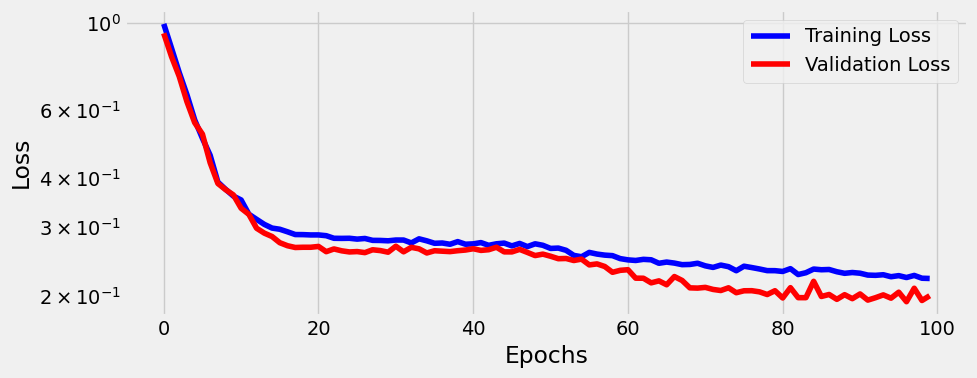

In [20]:
fig = sbs.plot_losses()